# 第5章 waifu2xによる画像の超解像

このノートブックでは、第5章で説明した waifu2x による画像の超解像の再現を行います。

## 環境構築

waifu2x は Torch7 を使って実装されています。このノートブックの内容をみなさんのお手元のコンピュータ上で再現するには、Torch7 の実行環境を構築し、加えて iTorch もインストールする必要があります。また、waifu2x を実行するには CUDA の環境が必須となります。CUDA が利用できる環境をお持ちでない読者は、たとえば AWS の g2.2xlarge インスタンスなど、CUDA を利用できる環境を提供しているクラウドを利用する方法があります。

### Torch7 のインストール

Torch7 のインストール方法は "[Getting started with Torch](http://torch.ch/docs/getting-started.html)" に記載されている通りです。

### iTorch のインストール

iTorch をインストールする前に Jupyter notebook の環境を構築する必要があります。Jupyter notebook の環境は第2章用の環境構築によってインストールされるので、第2章のノートブックを参照してください。

iTorch のインストール方法は "[Installing iTorch](https://github.com/facebook/iTorch#installing-itorch)" に記載されている通りです。

In [8]:
require 'image';
require 'waifu2x/lib/portable';
require 'waifu2x/lib/LeakyReLU';
gm = require 'graphicsmagick';
iproc = require 'waifu2x/lib/iproc';
image_loader = require 'waifu2x/lib/image_loader';
torch.setdefaulttensortype('torch.FloatTensor')

In [29]:
-- 以下の関数群は、waifu2x/lib/reconstruct.lua で定義されている関数群を改変し、
-- 隠れ層で生成される画像を取り出せるようにしたものです。

-- reconstruct_rgb の改変版
function reconstruct_rgb(model, x, offset, block_size, layer_images)
    local new_x = torch.Tensor():resizeAs(x):zero()
    local output_size = block_size - offset * 2
    local input = torch.CudaTensor(1, 3, block_size, block_size)

    for i = 1, x:size(2), output_size do
        for j = 1, x:size(3), output_size do
            if i + block_size - 1 <= x:size(2) and j + block_size - 1 <= x:size(3) then
                local index = {{}, {i, i + block_size - 1}, {j, j + block_size - 1}}
                input:copy(x[index])

                -- ネットワークへの入力画像ブロックを記録
                layer_images[("input_%d_%d"):format(i, j)] = x[index]

                local currentOutput = input
                for k = 1, #model.modules do
                    -- k 番目のモジュールの出力を計算
                    currentOutput = model.modules[k]:updateOutput(currentOutput)

                    -- 偶数番目のモジュール (畳み込みの後の活性化関数) と
                    -- 最終モジュール (出力の畳み込み) の出力画像を記録
                    if (k % 2 == 0 and k < #model.modules) or k == #model.modules - 1 then
                        -- 出力を <入力画像の幅> × <入力画像の高さ> × <チャネル数> の形式へ変換
                        local sz = currentOutput:size()
                        local forceDim = nn.View(-1):setNumInputDims(3)
                        local output = forceDim:updateOutput(currentOutput):float():view(sz[2], sz[3], sz[4])

                        -- 値の正規化
                        output:add(-torch.min(output))
                        output:div(torch.max(output))

                        -- ガンマ補正
                        output:pow(0.5)

                        -- すべてのチャネルの出力を格子状に並べた場合の全体のサイズを計算
                        local pad = 1
                        local cols = k == 2 and 8 or torch.ceil(torch.sqrt(sz[2]))
                        local rows = torch.ceil(sz[2] / cols)
                        local h = (sz[3] + pad) * rows - pad
                        local w = (sz[4] + pad) * cols - pad

                        -- すべてのチャネルの出力を image_data の中に格子状に配置
                        local image_data = torch.Tensor(1, h, w):fill(1.0)
                        for li = 1, rows do
                            local y_offset = (li - 1) * (sz[3] + pad) + 1
                            if y_offset + sz[3] - 1 <= h then
                                for lj = 1, cols do
                                    local x_offset = (lj - 1) * (sz[4] + pad) + 1
                                    if x_offset + sz[4] - 1 <= w then
                                        local l = (li - 1) * cols + lj
                                        if l <= sz[2] then
                                            local image_index = {{},
                                                {y_offset, y_offset + sz[3] - 1},
                                                {x_offset, x_offset + sz[4] - 1}}
                                            image_data[image_index] = output[{{l, l}, {}, {}}]
                                        end
                                    end
                                end
                            end
                        end

                        -- image_data を記録
                        layer_images[("layer_%d_output_%d_%d"):format(k, i, j)] = image_data
                    end
                end

                -- 出力画像ブロックを復元して記録
                local output = currentOutput:float():view(3, output_size, output_size)
                layer_images[("output_%d_%d"):format(i, j)] = output

                -- 出力画像ブロックを適切な位置に配置
                local output_index = {{},
                    {i + offset, offset + i + output_size - 1},
                    {offset + j, offset + j + output_size - 1}}
                new_x[output_index]:copy(output)
            end
        end
    end

    return new_x
end

-- reconstruct.scale_rgb の改変版
function scale_rgb(model, scale, x, offset, block_size)
    local layer_images = {}

    block_size = block_size or 128
    x = iproc.scale(x, x:size(3) * scale, x:size(2) * scale, "Box")

    -- ニューラルネットワークへ入力する前に最近傍補間で拡大した画像を記録
    layer_images["scaled_x"] = x

    local output_size = block_size - offset * 2
    local h_blocks = math.floor(x:size(2) / output_size) + ((x:size(2) % output_size == 0 and 0) or 1)
    local w_blocks = math.floor(x:size(3) / output_size) + ((x:size(3) % output_size == 0 and 0) or 1)
   
    local h = offset + h_blocks * output_size + offset
    local w = offset + w_blocks * output_size + offset
    local pad_h1 = offset
    local pad_w1 = offset
    local pad_h2 = (h - offset) - x:size(2)
    local pad_w2 = (w - offset) - x:size(3)
    local input = iproc.padding(x, pad_w1, pad_w2, pad_h1, pad_h2)

    -- ニューラルネットワークへ入力される画像 (パディングを挿入した画像) を記録
    layer_images["input"] = input

    local y = reconstruct_rgb(model, input, offset, block_size, layer_images)

    local output = image.crop(y, pad_w1, pad_h1, y:size(3) - pad_w2, y:size(2) - pad_h2)
    output[torch.lt(output, 0)] = 0
    output[torch.gt(output, 1)] = 1
    collectgarbage()

    return output, layer_images
end

## 入力画像のロードと確認

入力画像は 141x141 サイズの Vim のロゴです。この画像ファイルは `vimlogo-141x141.png` というファイル名でリポジトリに入れてあります。
画像を `image_loader.load_float` 関数でロードし、`itorch.image` 関数で表示します。

In [9]:
x, alpha = image_loader.load_float('vimlogo-141x141.png')

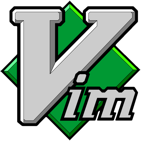

In [10]:
itorch.image(x)

## 学習済みニューラルネットワークのロード

学習済みのニューラルネットワーク (モデルと呼ぶ) は waifu2x のリポジトリの中にあります。
これを `torch.load` 関数でロードして使用します。

In [11]:
model = torch.load('waifu2x/models/anime_style_art_rgb/scale2.0x_model.t7', "ascii");

In [12]:
model:evaluate();

## 超解像処理

上で定義した `scale_rgb` 関数にモデル、入力画像、そして各パラメータを渡すことで超解像処理が実行されます。

In [30]:
-- パラメータ (waifu2x と同じ値を使用)
BLOCK_OFFSET = 7
SCALE = 2
BLOCK_SIZE = 128

new_x, layer_images = scale_rgb(model, SCALE, x, BLOCK_OFFSET, BLOCK_SIZE)

`new_x` に超解像処理の結果画像、`layer_images` の中に超解像処理の途中で生成された画像が記録されています。

`torch.image` 関数で、超解像処理の結果画像を表示してみましょう。

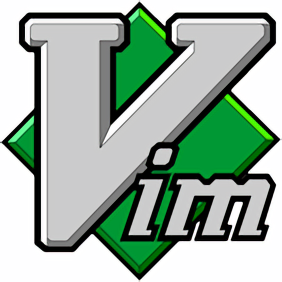

In [24]:
itorch.image(new_x)

このように、縦横が2倍のきれいな拡大画像になっていることが分かります。

`layer_images["scaled_x"]` に、最近傍補間による拡大画像が記録されているので、これも表示して確認してみましょう。

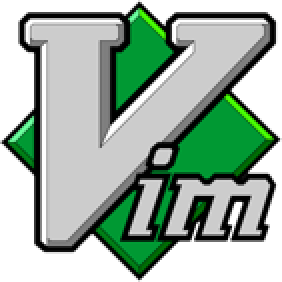

In [25]:
itorch.image(layer_images["scaled_x"])

In [ ]:
比べてみると、超解像処理の品質の高さがよく分かります。

## 超解像処理の途中で生成される画像の確認

`layer_images` に記録されている途中画像を確認してみましょう。

### ニューラルネットワークへの入力画像

まず、ニューラルネットワークへの入力画像を表示します。

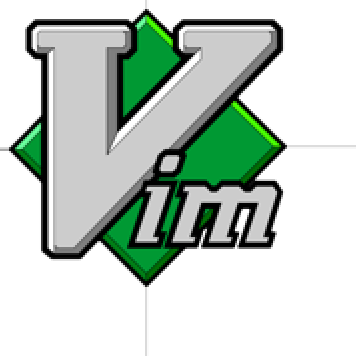

In [26]:
itorch.image(layer_images["input"])

ニューラルネットワークへの入力は、最近傍補間で拡大された画像に対して 7 ピクセルのパディングを挿入したものであると誌面では説明しました。
waifu2x はパディングを挿入する前に、画像をブロックとして切り出したときにちょうど良いサイズに調整します。
そのため、画像の右と下が元の画像よりも広がっています。

### 1つ目の畳み込み層の出力

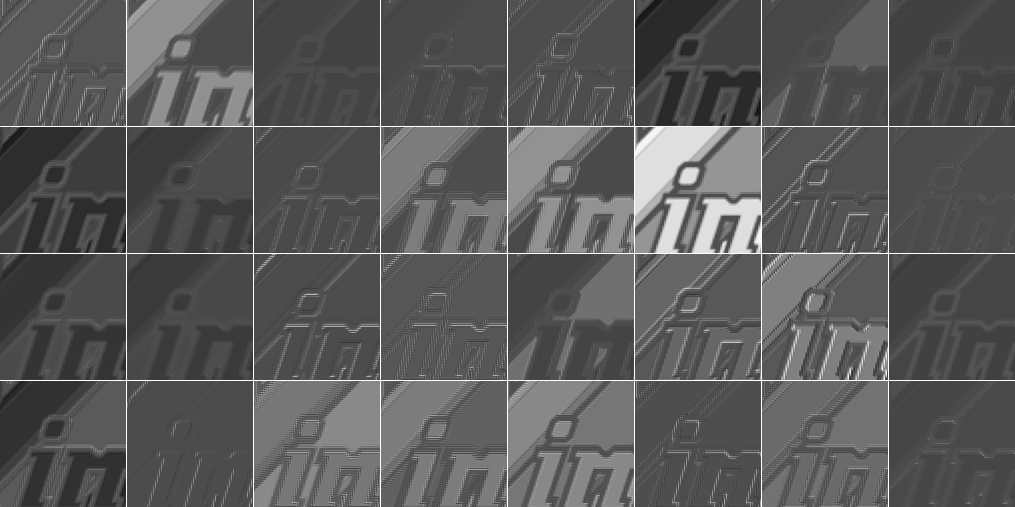

In [32]:
itorch.image(layer_images["layer_2_output_115_115"])

### 2つ目の畳み込み層の出力

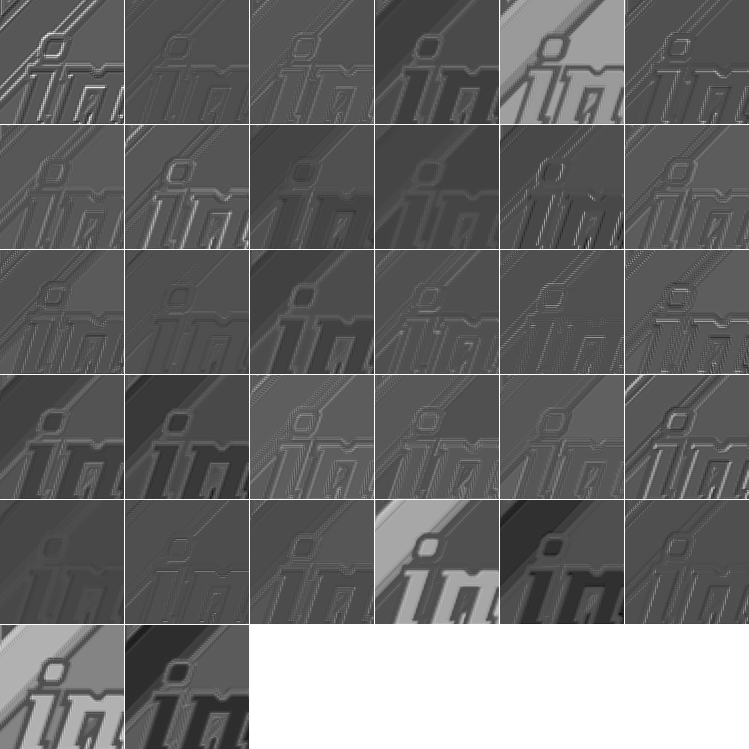

In [33]:
itorch.image(layer_images["layer_4_output_115_115"])

### 3つ目の畳み込み層の出力

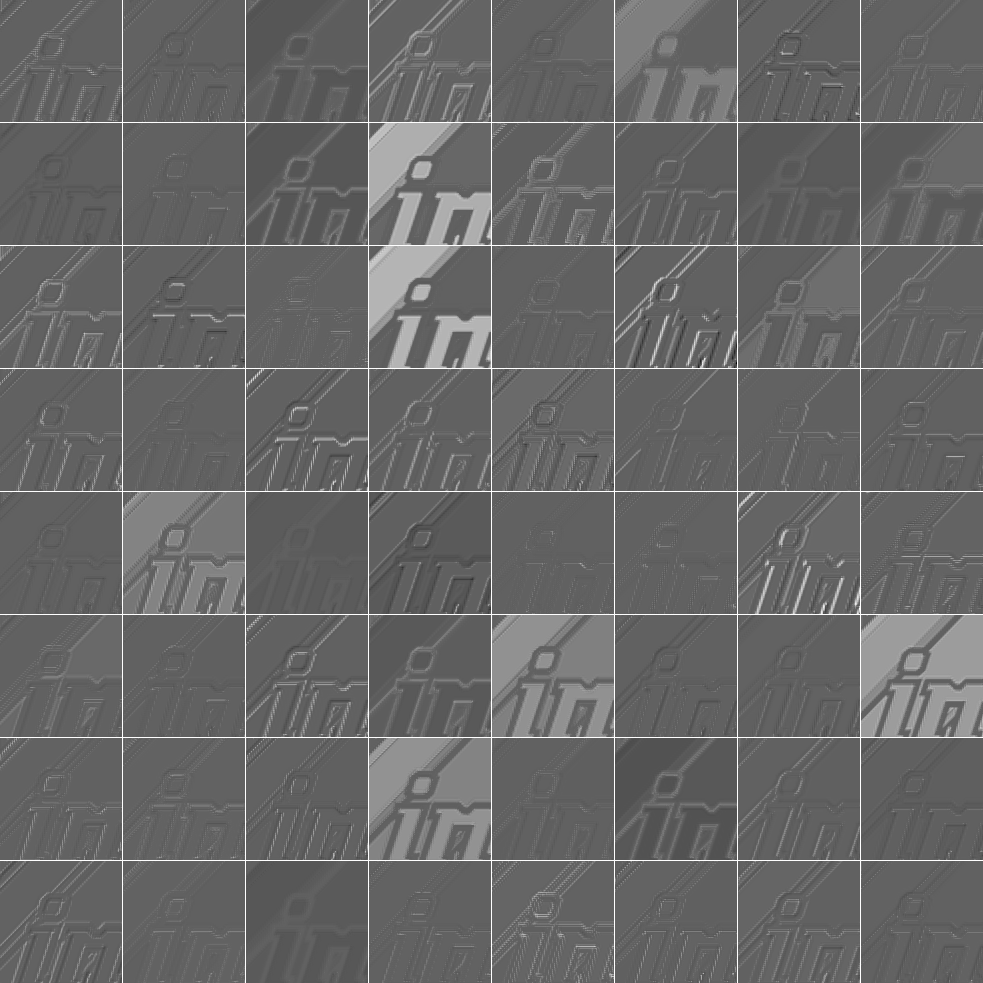

In [34]:
itorch.image(layer_images["layer_6_output_115_115"])

### 4つ目の畳み込み層の出力

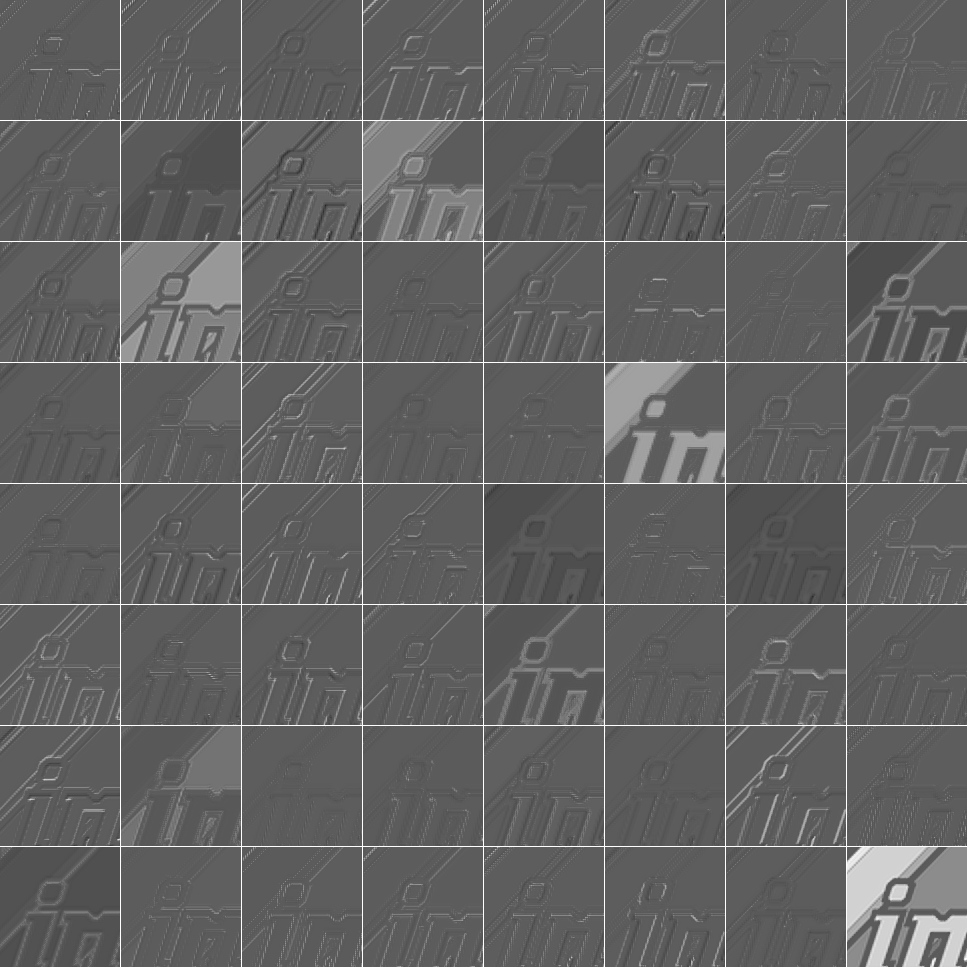

In [35]:
itorch.image(layer_images["layer_8_output_115_115"])

### 5つ目の畳み込み層の出力

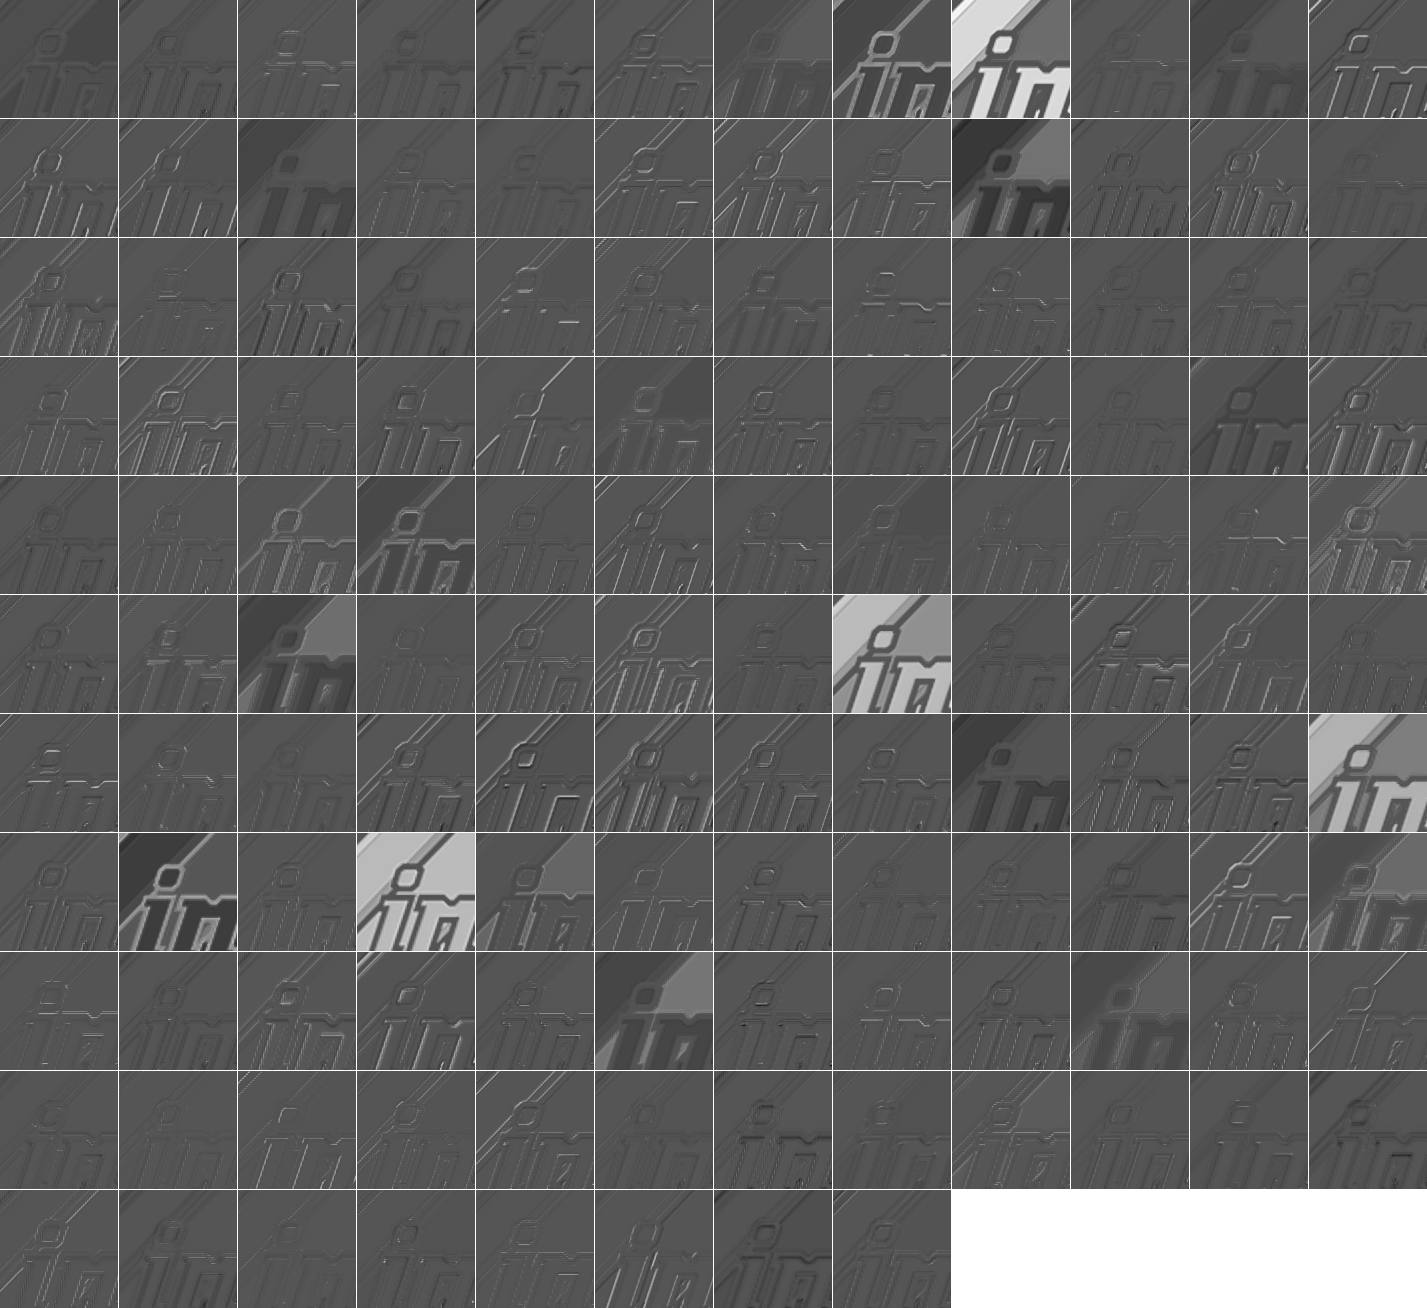

In [36]:
itorch.image(layer_images["layer_10_output_115_115"])

### 6つ目の畳み込み層の出力

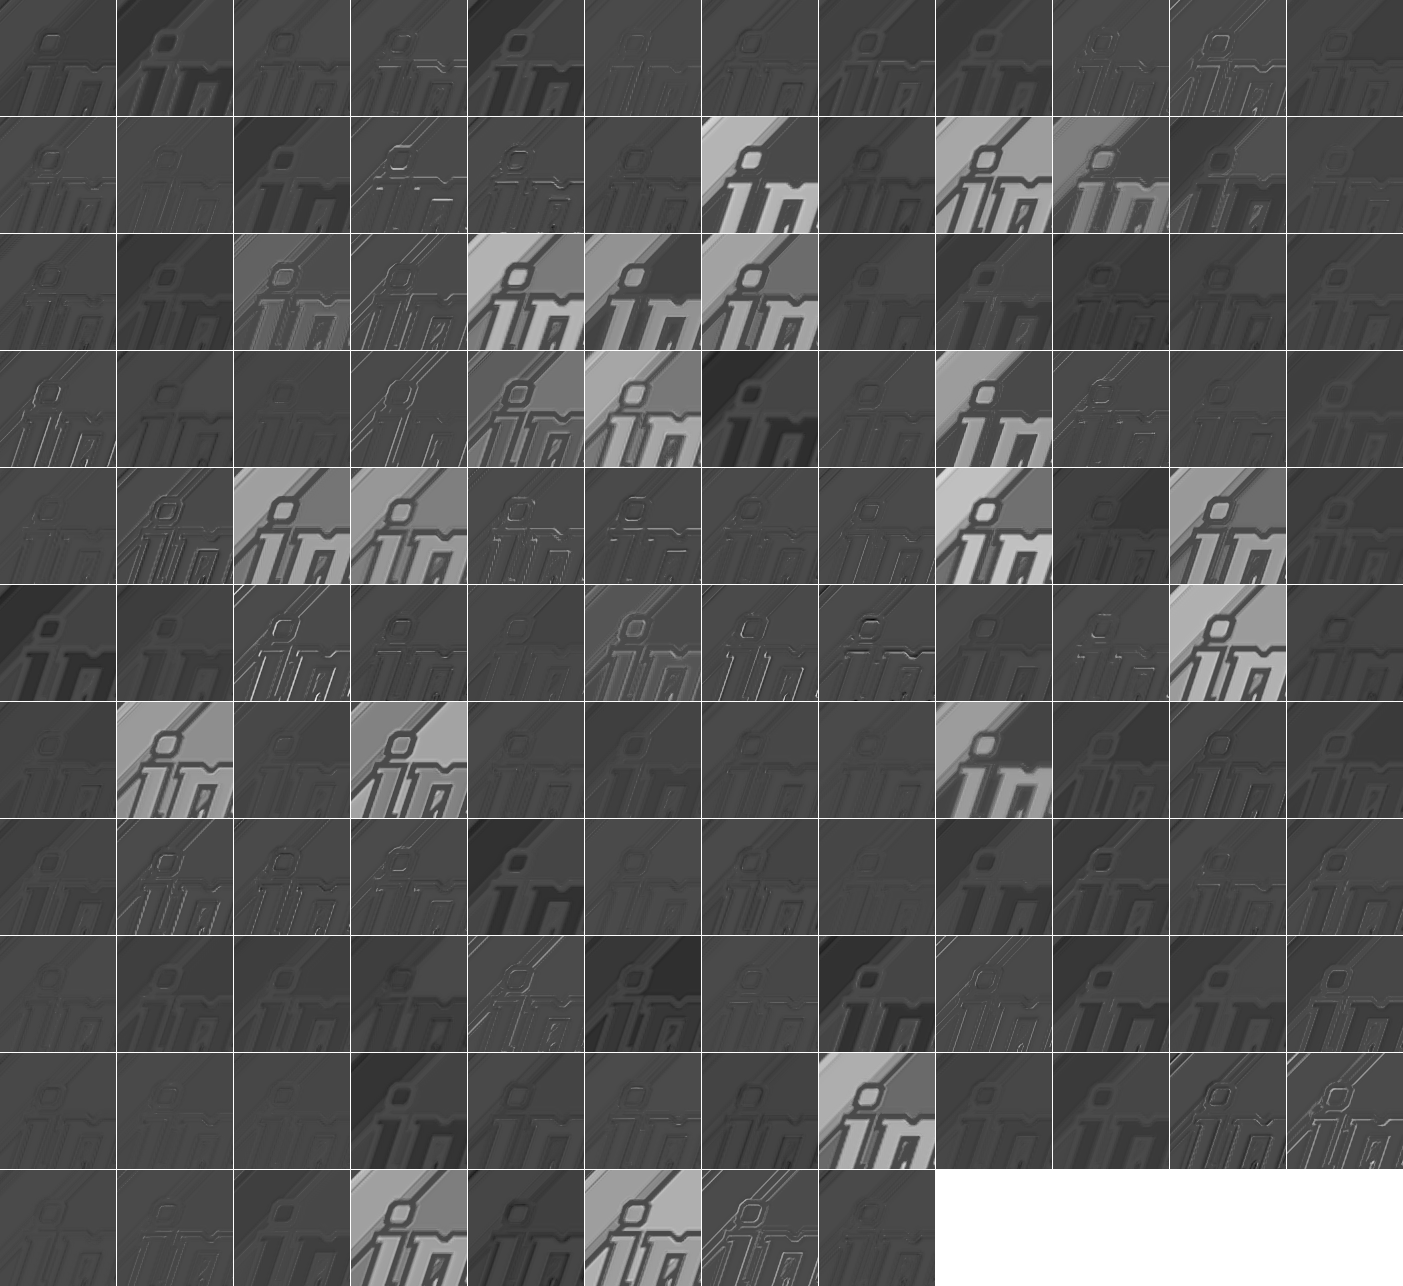

In [37]:
itorch.image(layer_images["layer_12_output_115_115"])

### 出力層の出力

出力層の出力をチャネル別に表示すると次のようになります。

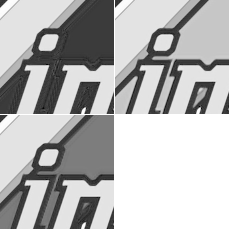

In [38]:
itorch.image(layer_images["layer_13_output_115_115"])

この3チャネルを合わせて1枚の画像にしたものが次の画像です。

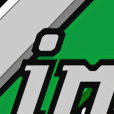

In [39]:
itorch.image(layer_images["output_115_115"])

### layer_images に記録されている画像の種類

上で確認した画像は Vim の i と m が含まれる領域のブロックについてでした。
`layer_images` にはそれ以外の領域の画像も記録されています。
以下に、`layer_images` のすべてのキーを示しますので、この中から見てみたいもの選んで `itorch.image` 関数で表示させてみてください。

In [31]:
for k,v in pairs(layer_images) do
    print(k)
end

layer_10_output_1_115	
layer_4_output_1_1	
output_1_115	
layer_10_output_1_229	
input_115_229	
layer_6_output_115_115	
layer_8_output_229_1	
layer_8_output_1_115	
output_115_229	
layer_12_output_229_115	
layer_8_output_115_229	
layer_2_output_1_115	
layer_4_output_1_115	
input	
input_115_1	
layer_6_output_115_229	
layer_10_output_229_115	
layer_12_output_1_115	
layer_12_output_115_229	
layer_6_output_1_229	
input_1_115	
layer_13_output_1_1	
layer_13_output_1_229	
layer_2_output_1_229	
layer_4_output_115_229	
input_115_115	
layer_10_output_1_1	
layer_2_output_115_229	
layer_13_output_115_229	
layer_2_output_115_115	
layer_4_output_115_115	
layer_13_output_115_115	
layer_12_output_1_1	
layer_2_output_229_1	
layer_4_output_229_1	
layer_6_output_1_115	
input_229_1	
layer_6_output_229_1	
input_1_1	
layer_12_output_115_115	
layer_8_output_229_115	
layer_13_output_115_1	
layer_12_output_229_229	
layer_10_output_229_229	
layer_13_output_1_115	
output_1_229	
layer_8_output_1_229	
layer_8_output